<a href="https://colab.research.google.com/github/kuo8129/GenAI/blob/main/20250603%E6%9C%9F%E6%9C%AB%E5%B0%88%E6%A1%88/20250603%E6%9C%9F%E6%9C%AB%E5%B0%88%E6%A1%882.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✨專案目標：打造臺灣旅遊智能推薦系統

#### 📌流程說明：

1. 使用者輸入想前往的臺灣縣市名稱
2. 至中央氣象署抓取天氣資訊
3. 根據當前時間及天氣資訊分析適合的景點類型
4. 篩選指定區域景點資訊進行語意檢索
5. 根據上述所有資訊生成旅遊建議
6. Gradio展示：1輸入+3輸出欄位
    *   輸入欄：臺灣縣市名稱
    *   輸出欄：天氣資訊、景點推薦、旅遊建議
---



## 安裝並匯入套件

In [1]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu openai requests aisuite[all] gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/

In [2]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from google.colab import userdata
from datetime import datetime, timezone, timedelta
import os
import re
import requests
import aisuite as ai
import gradio as gr

## 讀入並解壓縮檔案

In [3]:
URL = "https://drive.google.com/uc?export=download&id=14r31VvZEldn44Bd-4LlyAKfLWa0w67L7"
!wget -O faiss_db.zip "$URL"

--2025-06-02 06:45:08--  https://drive.google.com/uc?export=download&id=14r31VvZEldn44Bd-4LlyAKfLWa0w67L7
Resolving drive.google.com (drive.google.com)... 173.194.194.101, 173.194.194.138, 173.194.194.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.194.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=14r31VvZEldn44Bd-4LlyAKfLWa0w67L7&export=download [following]
--2025-06-02 06:45:08--  https://drive.usercontent.google.com/download?id=14r31VvZEldn44Bd-4LlyAKfLWa0w67L7&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12113479 (12M) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>]  11.55M  31.9MB

In [4]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.faiss    
  inflating: faiss_db/index.pkl      


## 自訂 E5 embedding 類別
* 資料庫的內容前面加上 "passage:" 當前綴詞，以增加精準度
* 問題的前面加上 "query:" 當前綴詞，以增加精準度

In [5]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

## 載入向量資料庫及原本的模型

In [6]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()
print("景點資料庫載入成功！")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

景點資料庫載入成功！


## 環境設置
* 讀入 Groq 與 中央氣象署 的 API key
* 使用 aisuite 套件打造對話機器人

In [7]:
groq_api_key = userdata.get('Groq')     # Groq API
os.environ['GROQ_API_KEY'] = groq_api_key
weather_api_key = userdata.get('Weather')  # 中央氣象署API
weather_url = "https://opendata.cwa.gov.tw/api/v1/rest/datastore/F-C0032-001"

In [8]:
# 使用Groq API生成回應
def get_ai_response(system_prompt, user_prompt):
    client = ai.Client()

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    response = client.chat.completions.create(
        model="groq:llama3-70b-8192",
        messages=messages
    )

    return response.choices[0].message.content

## 取得當前時間
* 獲取臺灣時區時間(+8)
* 格式化時間樣式

In [9]:
# 取得當前臺灣時間
def current_time():
    taiwan_timezone = timezone(timedelta(hours=+8))
    now = datetime.now(taiwan_timezone)
    weekdays = ['星期一', '星期二', '星期三', '星期四', '星期五', '星期六', '星期日']
    weekday_chinese = weekdays[now.weekday()]
    return f"{now.strftime('%Y-%m-%d %H:%M')} {weekday_chinese}"

In [10]:
current_time()

'2025-06-02 14:46 星期一'

## 驗證是否為有效地名
* 自動轉換「台」為「臺」
* 確保地名有效以便順利提取天氣資訊

In [11]:
# 定義臺灣縣市名稱
TAIWAN_LOCATIONS = [
    "臺北市", "新北市", "基隆市", "桃園市", "新竹市", "新竹縣",
    "苗栗縣", "臺中市", "彰化縣", "南投縣", "雲林縣", "嘉義市",
    "嘉義縣", "臺南市", "高雄市", "屏東縣", "宜蘭縣", "花蓮縣",
    "臺東縣", "澎湖縣", "金門縣", "連江縣"
]

In [12]:
# 檢查輸入的地名是否為有效的臺灣縣市名稱
def check_location(message):
    corrected_message = re.sub("台", "臺", message)  # 替換「台」為「臺」
    for location in TAIWAN_LOCATIONS:
        if re.search(corrected_message, location):
            return location
    return None

## 獲取天氣資訊
* 至中央氣象署擷取一般天氣預報
* 格式化天氣資訊

In [13]:
# 向中央氣象署查詢指定地區的天氣資料
def get_weather_data(location):
    params = {
        "Authorization": weather_api_key,
        "format": "JSON",
        "locationName": location
    }

    try:
        response = requests.get(weather_url, params=params)
        response.raise_for_status()
        data = response.json()

        if "records" in data and "location" in data["records"]:
            return data
        else:
            return None

    except requests.exceptions.RequestException as e:
        print(f"API 請求錯誤: {e}")
        return None

In [14]:
# 提取天氣資訊
def extract_weather_info(data):
    location_data = data['records']['location'][0]
    weather_elements = location_data['weatherElement']
    weather_info = {
        'location': location_data['locationName'],
    }

    for element in weather_elements:
        element_name = element['elementName']
        for time in element['time']:
            parameter = time['parameter']
            parameter_str = parameter['parameterName']
            if 'parameterUnit' in parameter:
                parameter_str += f" {parameter['parameterUnit']}"

            weather_info[element_name] = parameter_str

    return weather_info

In [15]:
extract_weather_info(get_weather_data("臺中市"))

{'location': '臺中市',
 'Wx': '陰時多雲短暫陣雨或雷雨',
 'PoP': '50 百分比',
 'MinT': '27 C',
 'CI': '舒適至易中暑',
 'MaxT': '34 C'}

In [16]:
# 將天氣資訊格式化為易讀的格式
def format_weather_info(weather_info):
    formatted_output = f"""天氣資訊：
    - 天氣狀況: {weather_info.get('Wx', '未知')}
    - 溫度範圍: {weather_info.get('MinT', '未知')} - {weather_info.get('MaxT', '未知')}
    - 降雨機率: {weather_info.get('PoP', '未知')}
    - 體感描述: {weather_info.get('CI', '未知')}"""

    return formatted_output.strip()

In [17]:
format_weather_info(extract_weather_info(get_weather_data("臺中市")))

'天氣資訊：\n    - 天氣狀況: 陰時多雲短暫陣雨或雷雨\n    - 溫度範圍: 27 C - 34 C\n    - 降雨機率: 50 百分比\n    - 體感描述: 舒適至易中暑'

## 景點類型分析

In [18]:
# 根據天氣資訊和時間分析適合的活動類型，並回傳關鍵字
def analyze_activity_type(weather_info, current_datetime):
    system_prompt = """你是專業的旅遊顧問，請根據天氣資訊和時間資訊判斷適合的活動類型。

    考慮因素：
    1. 天氣條件（雨天適合室內，晴天適合戶外）
    2. 時間限制（避開可能休館或關閉的景點）
    3. 星期幾（避開場館公休日或未開放的景點）
    4. 當前時間（太晚的話很多景點關閉）

    請回傳至少五個適合的活動類型關鍵字，用空格分隔，例如：
    - '室內 博物館 展覽 購物 觀光工廠'
    - '戶外 公園 海邊 步道 風景區 遊樂園 動物園'
    - '週一至週六開放 全日開放'
    - '24小時 夜市 夜景'

    並用繁體中文說明理由。"""

    user_prompt = f"""
    當前時間：{current_datetime} {weather_info}
    請分析並回傳至少十個適合的活動類型關鍵字及理由。"""

    try:
        activity_keywords = get_ai_response(system_prompt, user_prompt)
        return activity_keywords.strip()
    except Exception as e:
        print(f"活動類型分析失敗: {e}")
        return "景點 旅遊 推薦"

In [37]:
weatherinfo = format_weather_info(extract_weather_info(get_weather_data("臺中市")))
current_datetime = current_time()
analyze_activity_type(weatherinfo, current_datetime)

'Based on the current weather and time, I would recommend the following keywords, separated by spaces:\n\n**主要推薦**\n室內 博物館 展覽 購物 觀光工廠\n\n**理由**\n1. 天氣預報顯示 陰時多雲短暫陣雨或雷雨，降雨機率高達 50%，因此適合室內的選擇。\n2. 溫度範圍 - 34 C，體感描述為舒適至易中暑，室內活動能夠提供避雨和涼爽的環境。\n3. 星期一開放，避免休館或關閉的景點。\n\n**次要推薦**\n公園 步道 風景區 遊樂園 動物園\n\n**理由**\n1. 雖然降雨機率較高，但 陰時多雲短暫陣雨或雷雨 的天氣也可能會有短暫的晴天，因此戶外活動仍有可能實現。\n2. 溫度範圍 - 34 C，體感描述為舒適至易中暑，戶外活動也能夠享受到舒適的天氣。\n\n**其他選擇**\n週一至週六開放 全日開放\n24小時 夜市 夜景\n\n**理由**\n1. 星期一開放，避免休館或關閉的景點。\n2. 部分景點可能提供 24 小時或夜市夜景的活動，能夠提供更多選擇。'

## RAG 語意檢索(限定地區)
* 篩選指定地區景點資訊
* 根據關鍵字進行語意檢索

In [20]:
# 從載入的資料庫中先過濾地區，再進行語意搜尋
def search_attractions_rag_by_region(city_name, activity_keywords, top_k=10):
    try:
        all_docs = db.docstore._dict.values()

        # 篩選特定地區
        region_docs = [doc for doc in all_docs if city_name in doc.metadata.get("region", "")]
        print(f"找到 {len(region_docs)} 筆該地區資料")

        if not region_docs:
            return []

        # 對該地區的資料建臨時的向量索引
        region_vectorstore = FAISS.from_documents(region_docs, embedding_model)

        # 搜尋
        search_query = activity_keywords
        results = region_vectorstore.similarity_search(search_query, k=top_k)

        # 重組完整文件
        complete_docs = []
        processed_ids = set()

        for doc in results:
            doc_id = doc.metadata.get('id')  # 原始文件的 ID

            if doc_id and doc_id not in processed_ids:
                # 找出同一文件的所有 chunks
                same_doc_chunks = [d for d in all_docs if d.metadata.get('id') == doc_id]

                # 按 chunk_index 排序
                same_doc_chunks.sort(key=lambda x: x.metadata.get('chunk_index', 0))

                # 合併內容
                complete_content = '\n'.join([chunk.page_content for chunk in same_doc_chunks])

                # 創建完整文件
                complete_doc = Document(
                    page_content=complete_content,
                    metadata={
                        **same_doc_chunks[0].metadata,
                        'is_complete': True,
                        'total_chunks_merged': len(same_doc_chunks)
                    }
                )

                complete_docs.append(complete_doc)
                processed_ids.add(doc_id)

        return complete_docs[:top_k]

    except Exception as e:
        print(f"區域語意搜尋失敗: {e}")
        return []

In [21]:
search_attractions_rag_by_region("臺中市", "購物", top_k=5)

找到 519 筆該地區資料


[Document(metadata={'id': '387000000A_000081', 'name': '葫蘆墩文化中心', 'categories': ['文化類', '藝術類'], 'primary_category': '文化類', 'region': '臺中市', 'source': 'uploaded_docs/taiwan_attractions2.txt', 'chunk_index': 0, 'total_chunks': 3, 'is_complete': True, 'total_chunks_merged': 3}, page_content='ID:387000000A_000081\n景點名稱:葫蘆墩文化中心\n景點類別:文化類, 藝術類\n區域:臺中市\n地址:臺中市420豐原區圓環東路782 號\n電話:886-4-25260136\n開放時間:星期二至星期六 08:30-21:00，星期日 08:30-17:30\n門票:\n交通指南:豐原火車站下車，出站後直走至對面，步行約100餘公尺到達『豐原客運豐原總站』，搭乘(往東勢.谷關.卓蘭方向) 即可到達『文化中心站(站牌名稱)』。  *208路 豐原－卓蘭（豐原客運）*206路 豐原－東勢南站（豐原客運）*207路 豐原－谷關（豐原客運）*209路 豐原－東勢林場（豐原客運）*91路 舊庄－中興嶺（豐原客運）*235路 豐原圓環線*新市政中心－陽明大樓（中台灣...\n網站:\n景點介紹:位於豐原區圓環東路上，文藝氣息濃厚，是台中市民的文化、休閒重鎮。文化中心內保存、維護了許多重要地方文化資產。並按年度排定各項文物展覽，且設有預約導覽，進行展品之介紹解說，以發揮文化中心與民眾之間的互動及社教功能。近年來亦經常舉辦各式各樣有趣的文化活動。大臺中幅員遼闊，族群多元，人文薈萃，藝文人才輩出，本中心前身為「臺中市立文化中心」，係配合中央政府政策將文化建設列入12項重要計畫，每一縣市設立文化中心，於民國67年底開始規劃籌建，並於69年8月開工，而於71年12月底竣工，隨即於72年元旦落成啟用，將臺中市文化建設帶入新領域。成立以來，發揮地方特色，宣揚鄉土文化，倡導讀書風氣，建立書香社會，辦理藝文活動，提高民眾欣賞水準，舉辦假日表演廣場活動，提供民眾正當休閒活動，建立志工制度，擴大參與層面，辦

## 整理景點資訊
* 摘要景點介紹中的重要資訊
* 格式化景點資訊內容

In [22]:
# 從景點資料中提取景點介紹部分
def extract_introduction_from_content(content):
    lines = content.split('\n')
    introduction = ""

    for line in lines:
        if line.startswith('景點介紹:'):
            # 提取景點介紹後的所有內容
            introduction = line.replace('景點介紹:', '').strip()
            break

    return introduction

In [23]:
# 摘要景點介紹
def summarize_attraction_content(document):
    # 從Document對象中提取景點介紹部分
    content = document.page_content

    # 解析景點介紹部分
    introduction = extract_introduction_from_content(content)

    system_prompt = """你是專業的旅遊文案編輯，請將景點的詳細介紹摘要成簡潔的重點描述。
    摘要應該：
    1. 保持在100字以內
    2. 突出景點的特色和亮點
    3. 用吸引人的語調描述
    4. 去除重複和冗餘的資訊
    5. 保留最重要的文化特色或歷史背景
    請只回答摘要內容，不需要其他說明。請用台灣習慣的中文回應。"""

    user_prompt = f"請摘要以下景點介紹：\n{introduction}"

    return get_ai_response(system_prompt, user_prompt)

In [24]:
# 解析景點資料中的所有欄位
def parse_attraction_data(content):
    lines = content.split('\n')
    data = {}

    for line in lines:
        if ':' in line:
            key, value = line.split(':', 1)
            key = key.strip()
            value = value.strip()

            if key == 'ID':
                data['id'] = value
            elif key == '景點名稱':
                data['name'] = value
            elif key == '景點類別':
                data['categories'] = [cat.strip() for cat in value.split(',') if cat.strip()]
            elif key == '區域':
                data['region'] = value
            elif key == '地址':
                data['address'] = value
            elif key == '電話':
                data['phone'] = value
            elif key == '開放時間':
                data['opening_hours'] = value
            elif key == '門票':
                data['ticket_price'] = value
            elif key == '交通指南':
                data['transportation'] = value
            elif key == '網站':
                data['website'] = value
            elif key == '景點介紹':
                data['introduction'] = value

    return data

In [25]:
# 整理景點資訊，只保留有資料的項目
def process_attraction_summary(document):
    try:
        # 解析所有欄位資訊
        content = document.page_content
        attraction_data = parse_attraction_data(content)

        # 生成摘要
        summary = summarize_attraction_content(document)

        # 建立欄位資料
        all_fields = {
            '名稱': attraction_data.get('name', document.metadata.get('name', '')),
            '地址': attraction_data.get('address', ''),
            '電話': attraction_data.get('phone', ''),
            '開放時間': attraction_data.get('opening_hours', ''),
            '門票': attraction_data.get('ticket_price', ''),
            '交通': attraction_data.get('transportation', ''),
            '網站': attraction_data.get('website', ''),
            '簡介': summary,
        }

        # 只保留有資料的欄位
        result = {}
        for key, value in all_fields.items():
            if value and str(value).strip():
                result[key] = value

        return result

    except Exception as e:
        print(f"處理景點摘要時發生錯誤: {e}")
        return None

In [26]:
# 批量處理多個景點
def batch_summarize_attractions(documents):
    summaries = []
    for doc in documents:
        result = process_attraction_summary(doc)
        if result:
            summaries.append(result)

    return summaries

In [27]:
batch_summarize_attractions(search_attractions_rag_by_region("臺中市", "購物", top_k=5))

找到 519 筆該地區資料


[{'名稱': '葫蘆墩文化中心',
  '地址': '臺中市420豐原區圓環東路782 號',
  '電話': '886-4-25260136',
  '開放時間': '星期二至星期六 08:30-21:00，星期日 08:30-17:30',
  '交通': '豐原火車站下車，出站後直走至對面，步行約100餘公尺到達『豐原客運豐原總站』，搭乘(往東勢.谷關.卓蘭方向) 即可到達『文化中心站(站牌名稱)』。  *208路 豐原－卓蘭（豐原客運）*206路 豐原－東勢南站（豐原客運）*207路 豐原－谷關（豐原客運）*209路 豐原－東勢林場（豐原客運）*91路 舊庄－中興嶺（豐原客運）*235路 豐原圓環線*新市政中心－陽明大樓（中台灣...',
  '簡介': "葫蘆墩文化中心Located in the heart of Taichung, this cultural hub is a must-visit for locals and tourists alike. The center showcases the city's rich cultural heritage, with diverse exhibitions and interactive guided tours. Enjoy a wide range of cultural activities, from traditional crafts to international exchange programs. Experience the beauty of Taiwanese culture and art at this iconic institution!"},
 {'名稱': '臺中市港區藝術中心',
  '地址': '臺中市436清水區忠貞路21號',
  '電話': '886-4-26274568',
  '開放時間': '展覽廳：週二至週日9：00～17：30（週一休館） 演藝廳：依節目時程開放 戶外廣場：每日5：00～22：00',
  '交通': '1.公車-搭乘111、123、128、303、304、306、306區公車，於清水國中站或港區藝術中心站下車。2.火車-搭乘經由海線火車至清水站下車，轉乘計程車約6分鐘可抵達。3.高鐵-請至臺中站下車，搭乘計程車約4

## 生成旅遊建議

In [28]:
# 生成綜合的旅遊建議
def generate_comprehensive_travel_advice(current_datetime, weather_info, location, activity_analysis, attractions):
    attractions_text = ""
    for i, attraction in enumerate(attractions, 1):
        attractions_text += f"\n【景點 {i}】\n"
        for key, value in attraction.items():
            attractions_text += f"- {key}：{value}\n"
        attractions_text += "\n"

    system_prompt = """
    你是專業的旅遊顧問，擅長撰寫具有在地風情與吸引力的旅遊推薦內容。
    請根據提供的時間、天氣、活動類型與景點資訊，撰寫一段自然且完整的旅遊推薦文：
    - 開場應親切自然，簡要描繪目前的天氣與出遊氛圍
    - 根據提供的景點資訊撰寫段落式介紹，描述每個景點的特色與推薦理由
    - 不需要規劃路線、不建議遊覽順序
    - 結尾可加入實用提醒，例如天氣相關的服裝建議、交通建議等
    - 請**不要**使用任何標題或條列，內容請以自然段落書寫
    請以繁體中文回應，用專業但不失親切的語氣呈現，展現你對台灣文化與在地特色的了解。文字要生動有畫面感，讓讀者產生想親自走訪的興趣。"""

    user_prompt = f"""
    請為以下情況生成旅遊建議：
    **當前時間**：{current_datetime}
    **天氣狀況**：{weather_info}
    **目標地區**：{location}
    **活動類型分析**：{activity_analysis}
    **推薦景點資訊**：{attractions_text}
    請用繁體中文生成一份完整的旅遊建議。"""

    try:
        recommendation = get_ai_response(system_prompt, user_prompt)
        return recommendation
    except Exception as e:
        print(f"AI 生成建議失敗: {e}")
        return None

In [29]:
generate_comprehensive_travel_advice(current_time(), format_weather_info(extract_weather_info(get_weather_data("臺中市"))), "臺中市", analyze_activity_type(format_weather_info(extract_weather_info(get_weather_data("臺中市"))), current_time()), batch_summarize_attractions(search_attractions_rag_by_region("臺中市", "購物", top_k=5)))

找到 519 筆該地區資料


'隨著星期一的午後陽光緩緩昇起，今天的天氣預計多雲短暫陣雨或雷雨，溫度也維持在舒適至易中暑的範圍內。考慮到這樣的天氣情況，我們寧願選擇一些室內活動，讓我們避開外面的陣雨和炎熱的午後陽光。\n\n在豐原區，我們可以造訪葫蘆墩文化中心，這裡是台中市民的文化、休閒重鎮，中心保存地方文化資產，舉辦各式文化活動，設有預約導覽，發揮文化中心與民眾之間的互動及社教功能。我們可以在這裡學習豐原的文化和藝術，體驗豐原的生活氣息。\n\n或者，我們可以造訪位於清水區的臺中市港區藝術中心，這裡是多功能藝術展演場所，涵蓋展覽廳、演藝廳、美術家資料館、戶外劇場休閒區等設施，提供藝文演出、民眾文化休閒活動，並推廣地方藝術創作。這裡的建築仿閩南風格設計，古樸典雅，帶給我們一種不同於一般博物館的藝術氣息。\n\n如果我們想要體驗一些城市的藝術氣息，我們可以造訪精明一街，這裡是都市中的藝術街道，美麗步道、雅緻招牌、明亮櫥窗，精品服飾、茶藝咖啡、異國風味餐館、畫廊、露天座椅、音樂會、藝文活動盛行，讓我們感覺置身巴黎香榭大道。\n\n如果我們想要探索一些獨特的文化，我們可以造訪台灣味噌釀造文化館，這裡是台灣唯一的味噌主題觀光工廠！我們可以在這裡參觀教育導覽、手做DIY、選購優質味噌和調醬產品，包括有機味噌、信州味噌、首選醬和韓式味噌辣醬等二十多種得獎伴手禮！\n\n總之，今天的室內活動將讓我們體驗豐原的文化和藝術，避開外面的陣雨和炎熱的午後陽光。\n\n實用提醒：\n\n* 請穿著舒適、輕便的服裝，適應今天的天氣情況。\n* 請提前預備雨具，以備不時之需。\n* 請注意交通信息，避免交通阻塞。\n* 請提前預約導覽或活動，避免時間衝突。'

## 用 Gradio 展示旅遊推薦系統

In [38]:
# 旅遊推薦主函式
def process_travel_recommendation(city_input):
    try:
        # 檢查地名是否有效
        valid_location = check_location(city_input)

        if not valid_location:
            error_msg = f"❌ 「{city_input}」不是有效的臺灣縣市名稱\n\n請輸入正確的縣市名稱，例如：臺北市、新北市、臺中市等。"
            return error_msg, "", ""

        # 取得當前時間
        current_datetime = current_time()

        # 取得天氣資料
        weather_data = get_weather_data(valid_location)
        if not weather_data:
            weather_info_markdown = f"❌ 無法取得 {valid_location} 的天氣資訊\n\n請稍後再試或聯繫系統管理員。"
            weather_info = {}
        else:
            weather_info = extract_weather_info(weather_data)
            weather_info_text = format_weather_info(weather_info)

            # 將天氣資訊轉換為 Markdown 格式，每個項目換行
            weather_info_replace = weather_info_text.replace('天氣資訊：', '').replace('    - ', '\n• ').replace('- ', '\n• ')
            weather_info_markdown = f"""🌡️ **{valid_location}天氣資訊**

{weather_info_replace}

📅 **更新時間**：{current_datetime}"""

        # 分析活動類型
        activity_analysis = analyze_activity_type(weather_info, current_datetime)

        # 搜尋景點
        documents = search_attractions_rag_by_region(valid_location, activity_analysis, top_k=3)

        if not documents:
            attractions_markdown = f"""🔍 很抱歉，目前沒有找到 {valid_location} 的景點資訊。

建議您可以：

• 檢查縣市名稱是否正確

• 嘗試搜尋其他縣市

• 稍後再試"""

            attractions = []
        else:
            # 批量處理景點摘要
            attractions = batch_summarize_attractions(documents)

            # 格式化景點資訊為 Markdown 格式
            attractions_markdown = ""
            for i, attraction in enumerate(attractions, 1):
                attractions_markdown += f"### 🏛️ {attraction.get('名稱', f'景點 {i}')}\n\n"

                # 顯示景點詳細資訊
                for key, value in attraction.items():
                    if key != '名稱':
                        icon_map = {
                            '地址': '📍',
                            '電話': '☎️',
                            '開放時間': '🕘',
                            '門票': '💰',
                            '交通': '🚗',
                            '網站': '🌐',
                            '簡介': '📝'
                        }
                        icon = icon_map.get(key, '•')
                        attractions_markdown += f"**{icon} {key}**：{value}\n\n"

                attractions_markdown += "---\n\n"

        # 生成綜合旅遊建議
        if attractions:
            travel_advice = generate_comprehensive_travel_advice(
                current_datetime, weather_info, valid_location, activity_analysis, attractions
            )
            advice_markdown = f"""{travel_advice}

---

**💡 溫馨提醒**：

• 出發前請確認景點開放時間

• 建議攜帶雨具以備不時之需

• 注意交通狀況，預留充足時間"""

        else:
            advice_markdown = f"""由於沒有找到 {valid_location} 的詳細景點資訊，建議您可以嘗試搜尋其他縣市，或稍後再試。

**根據目前的天氣狀況**：
{weather_info_text}

**建議活動類型**：
{activity_analysis}

---

**💡 溫馨提醒**：

• 可以嘗試搜尋鄰近縣市的景點

• 關注當地旅遊官方網站獲取最新資訊"""

        return weather_info_markdown, attractions_markdown, advice_markdown

    except Exception as e:
        error_msg = f"❌ 系統發生錯誤：{str(e)}\n\n請稍後再試或聯繫系統管理員。"
        return error_msg, "", ""

In [39]:
css = """
.weather-box {
    background: #ffffff;
    padding: 10px;
    border-radius: 15px;
    color: #333333;
    margin: 0px;
    border: 2px solid #74b9ff;
    box-shadow: 0 2px 8px rgba(0, 0, 0, 0.1);
}

.attractions-box {
    background: #ffffff;
    padding: 10px;
    border-radius: 15px;
    color: #333333;
    margin: 0px;
    border: 2px solid #fd79a8;
    box-shadow: 0 2px 8px rgba(0, 0, 0, 0.1);
}

.advice-box {
    background: #ffffff;
    padding: 10px;
    border-radius: 15px;
    color: #333333;
    margin: 0px;
    border: 2px solid #00b894;
    box-shadow: 0 2px 8px rgba(0, 0, 0, 0.1);
}

.example-btn {
    margin: 2px;
    padding: 8px 16px;
    border-radius: 20px;
    background: #f8f9fa;
    border: 2px solid #dee2e6;
    transition: all 0.3s ease;
}

.example-btn:hover {
    background: #e9ecef;
    border-color: #6c757d;
    transform: translateY(-2px);
}

.main-container {
    max-width: 1200px;
    margin: 0 auto;
    padding: 20px;
}

.city-input {
    font-size: 16px;
    padding: 12px;
    border-radius: 10px;
    border: 2px solid #dee2e6;
    transition: border-color 0.3s ease;
}

.city-input:focus {
    border-color: #74b9ff;
    box-shadow: 0 0 0 3px rgba(116, 185, 255, 0.1);
}

.section-title {
    font-size: 1.2em;
    font-weight: bold;
    margin-bottom: 0px;
    padding: 10px;
    border-radius: 8px;
}

.weather-title {
    background: #e3f2fd;
    color: #1976d2;
    border-left: 4px solid #74b9ff;
}

.attractions-title {
    background: #fce4ec;
    color: #c2185b;
    border-left: 4px solid #fd79a8;
}

.advice-title {
    background: #e8f5e8;
    color: #388e3c;
    border-left: 4px solid #00b894;
}
"""

In [40]:
# 建立 Gradio 使用者介面
def create_gradio_interface():

    # 建立介面
    with gr.Blocks(css=css, title="🏝️ 臺灣旅遊推薦系統") as interface:
        gr.Markdown("""
        # 🏝️ 臺灣旅遊推薦系統

        輸入您想前往的臺灣縣市名稱，系統將會為您提供：
        - 🌤️ **即時天氣資訊**
        - 🏛️ **精選景點推薦**
        - 🎯 **個人化旅遊建議**

        ---
        """)

        # 範例按鈕
        gr.Markdown("### 💡 試試這些熱門城市：")
        with gr.Row():
            example_cities = ["臺北市", "新北市", "臺中市", "臺南市", "高雄市"]
            example_buttons = []

            for city in example_cities:
                example_btn = gr.Button(city, size="sm", elem_classes=["example-btn"])
                example_buttons.append((example_btn, city))

        with gr.Row():
            with gr.Column(scale=1):
                city_input = gr.Textbox(
                    label="🏙️ 請輸入臺灣縣市名稱",
                    placeholder="例如：臺北市、新北市、臺中市...",
                    lines=1,
                    elem_classes=["city-input"]
                )
                submit_btn = gr.Button("🔍 開始搜尋", variant="primary", size="lg")

        # 添加區塊標題
        with gr.Row():
            with gr.Column(scale=1):
                gr.HTML('<div class="section-title weather-title">🌤️ 天氣資訊</div>')
                weather_output = gr.Markdown(
                    elem_classes=["weather-box"],
                    value="請輸入縣市名稱開始查詢天氣資訊..."
                )

            with gr.Column(scale=1):
                gr.HTML('<div class="section-title attractions-title">🏛️ 景點推薦</div>')
                attractions_output = gr.Markdown(
                    elem_classes=["attractions-box"],
                    value="請輸入縣市名稱開始查詢景點推薦..."
                )

            with gr.Column(scale=1):
                gr.HTML('<div class="section-title advice-title">🎯 旅遊建議</div>')
                advice_output = gr.Markdown(
                    elem_classes=["advice-box"],
                    value="請輸入縣市名稱開始獲取旅遊建議..."
                )

        # 按鈕點擊事件
        submit_btn.click(
            fn=process_travel_recommendation,
            inputs=[city_input],
            outputs=[weather_output, attractions_output, advice_output]
        )

        # Enter鍵觸發事件
        city_input.submit(
            fn=process_travel_recommendation,
            inputs=[city_input],
            outputs=[weather_output, attractions_output, advice_output]
        )

        # 設定範例按鈕的點擊事件
        def create_example_click(city_name):
            def example_click():
                results = process_travel_recommendation(city_name)
                return city_name, results[0], results[1], results[2]
            return example_click

        for example_btn, city in example_buttons:
            example_btn.click(
                fn=create_example_click(city),
                inputs=[],
                outputs=[city_input, weather_output, attractions_output, advice_output]
            )

        # 底部說明
        gr.Markdown("""
        ---

        ### 📝 使用說明
        - 請輸入完整的臺灣縣市名稱（如：臺北市、新北市等）
        - 系統會自動查詢當地天氣並推薦適合的景點
        - 天氣資訊來源：中央氣象署
        - 景點資料來源：政府資料開放平台

        ### ⚠️ 注意事項
        - 系統支援繁體中文，會自動轉換「台」為「臺」
        - 建議在出發前再次確認景點開放時間
        - 如遇系統問題，請稍後再試
        """)

    return interface

In [44]:
demo = create_gradio_interface()
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://576ce0ca258402b99b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://576ce0ca258402b99b.gradio.live


#### 初始畫面

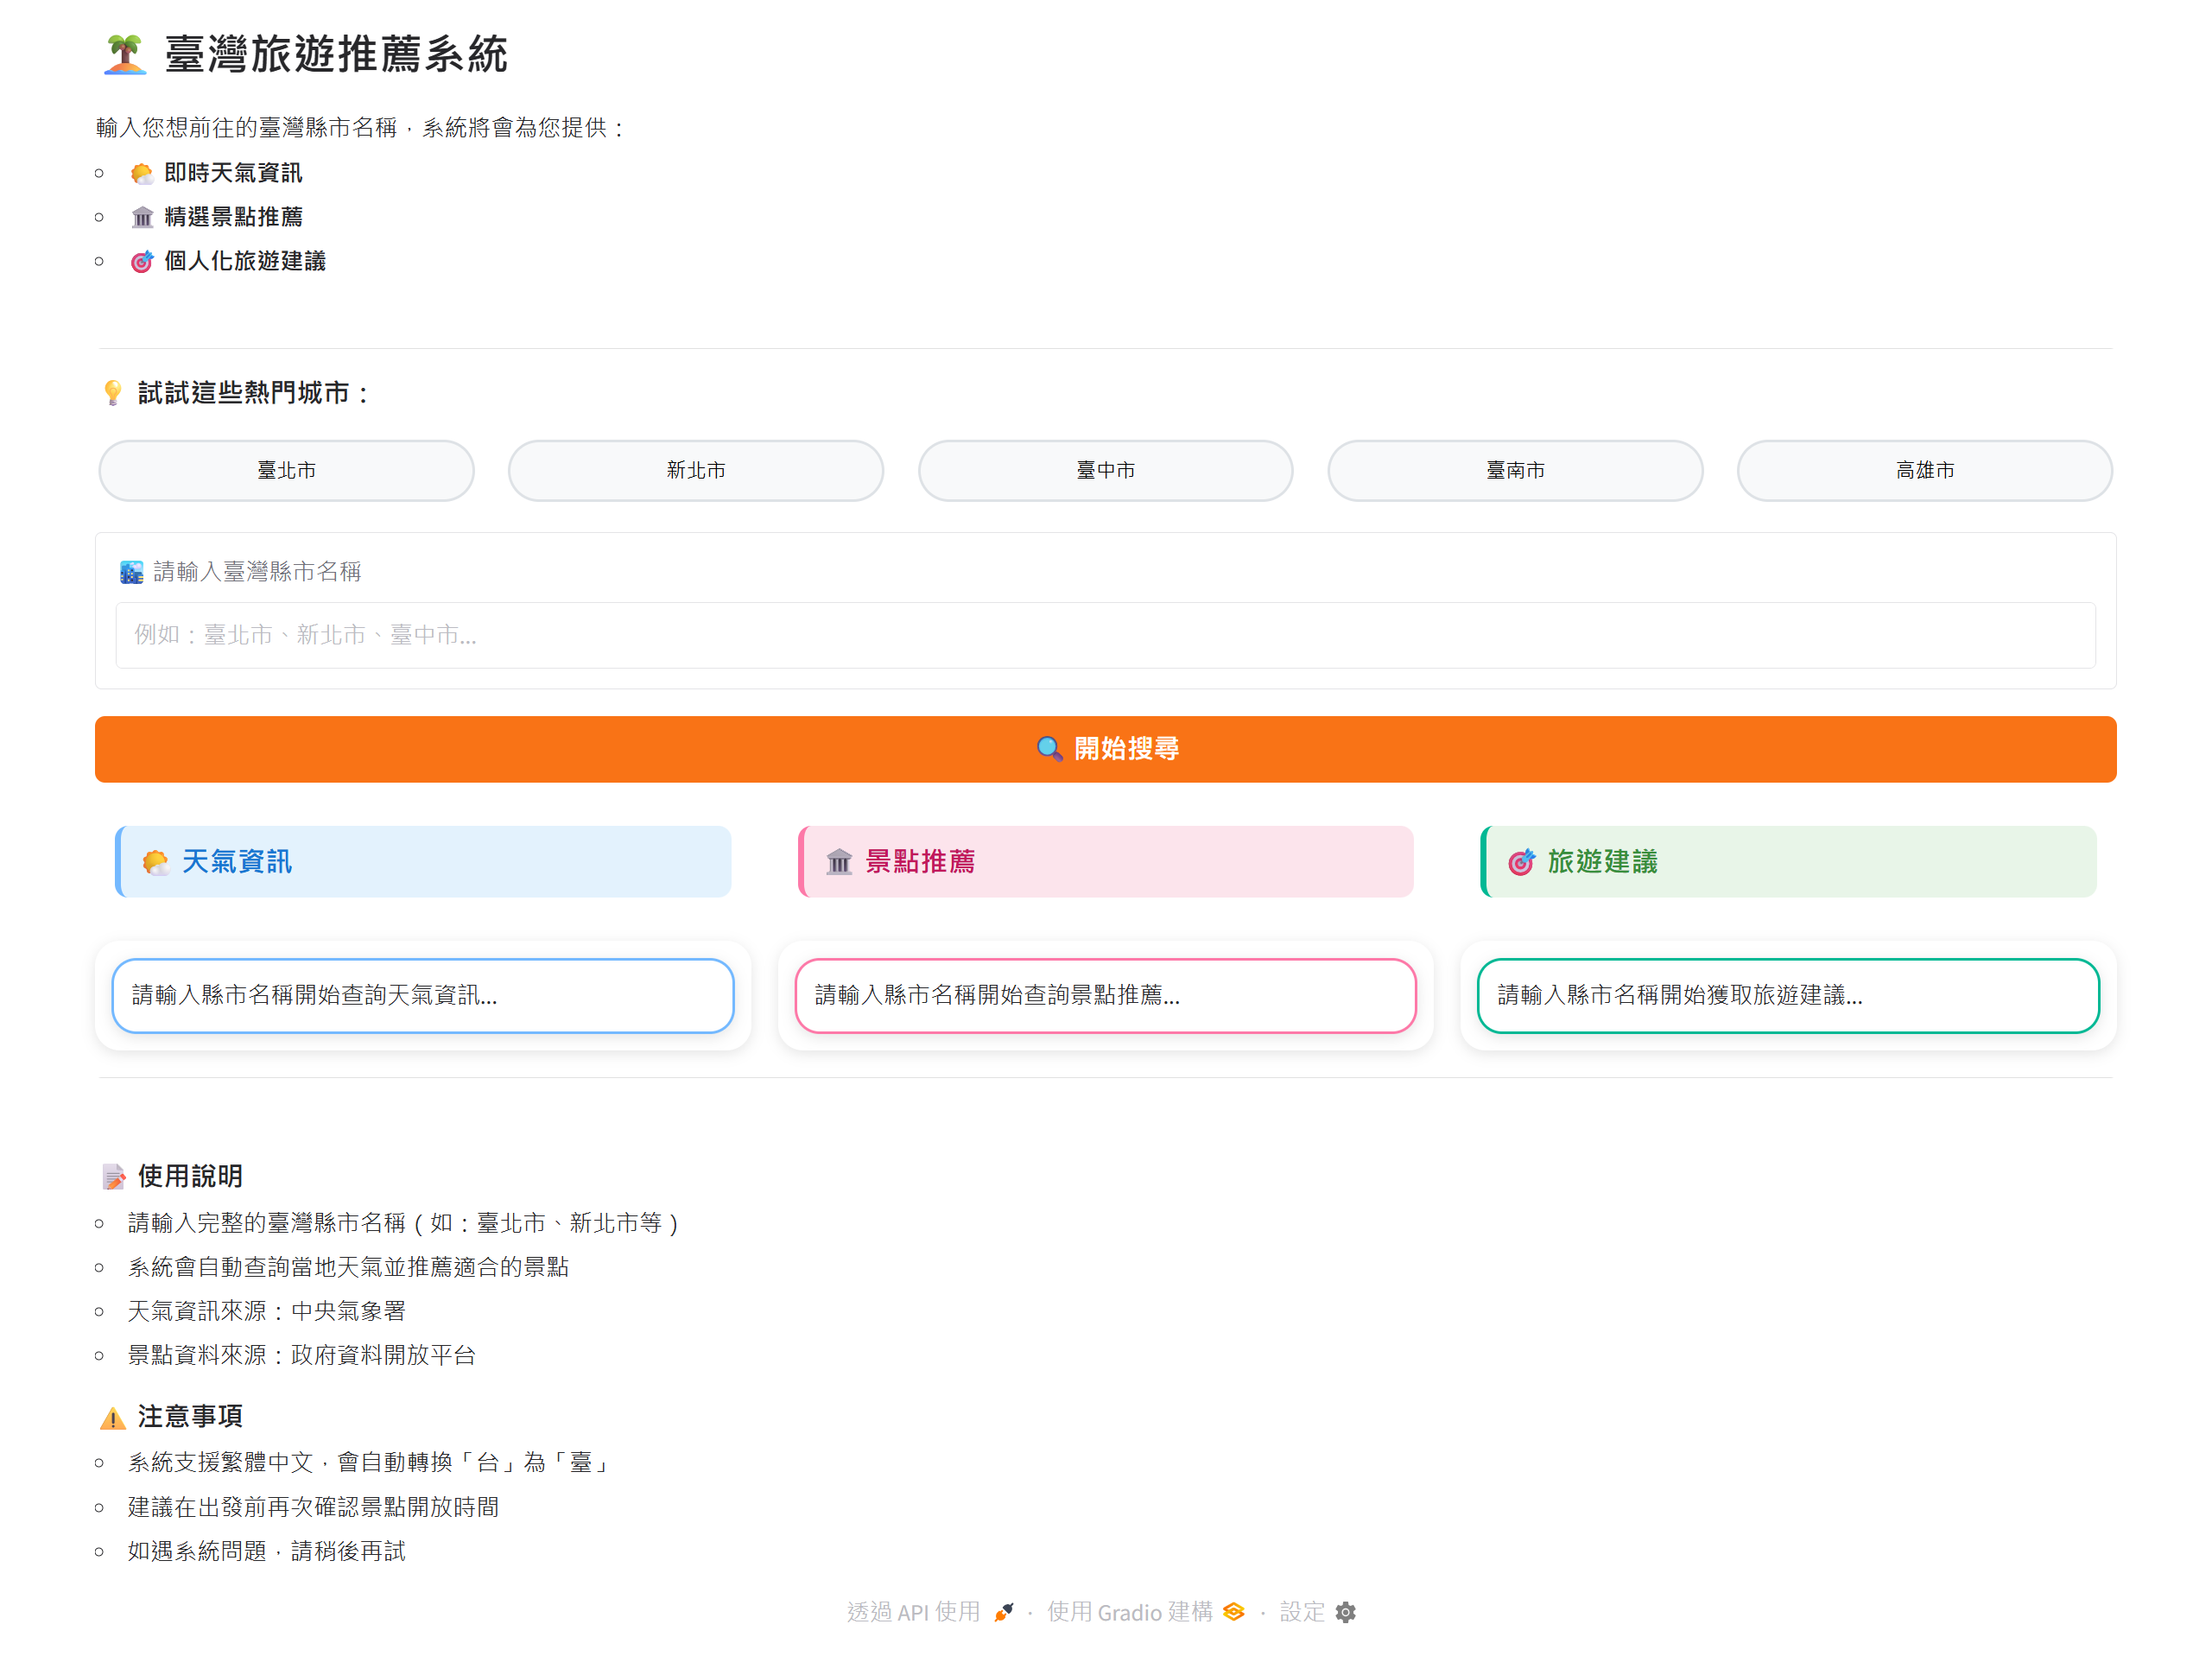

#### 查詢畫面

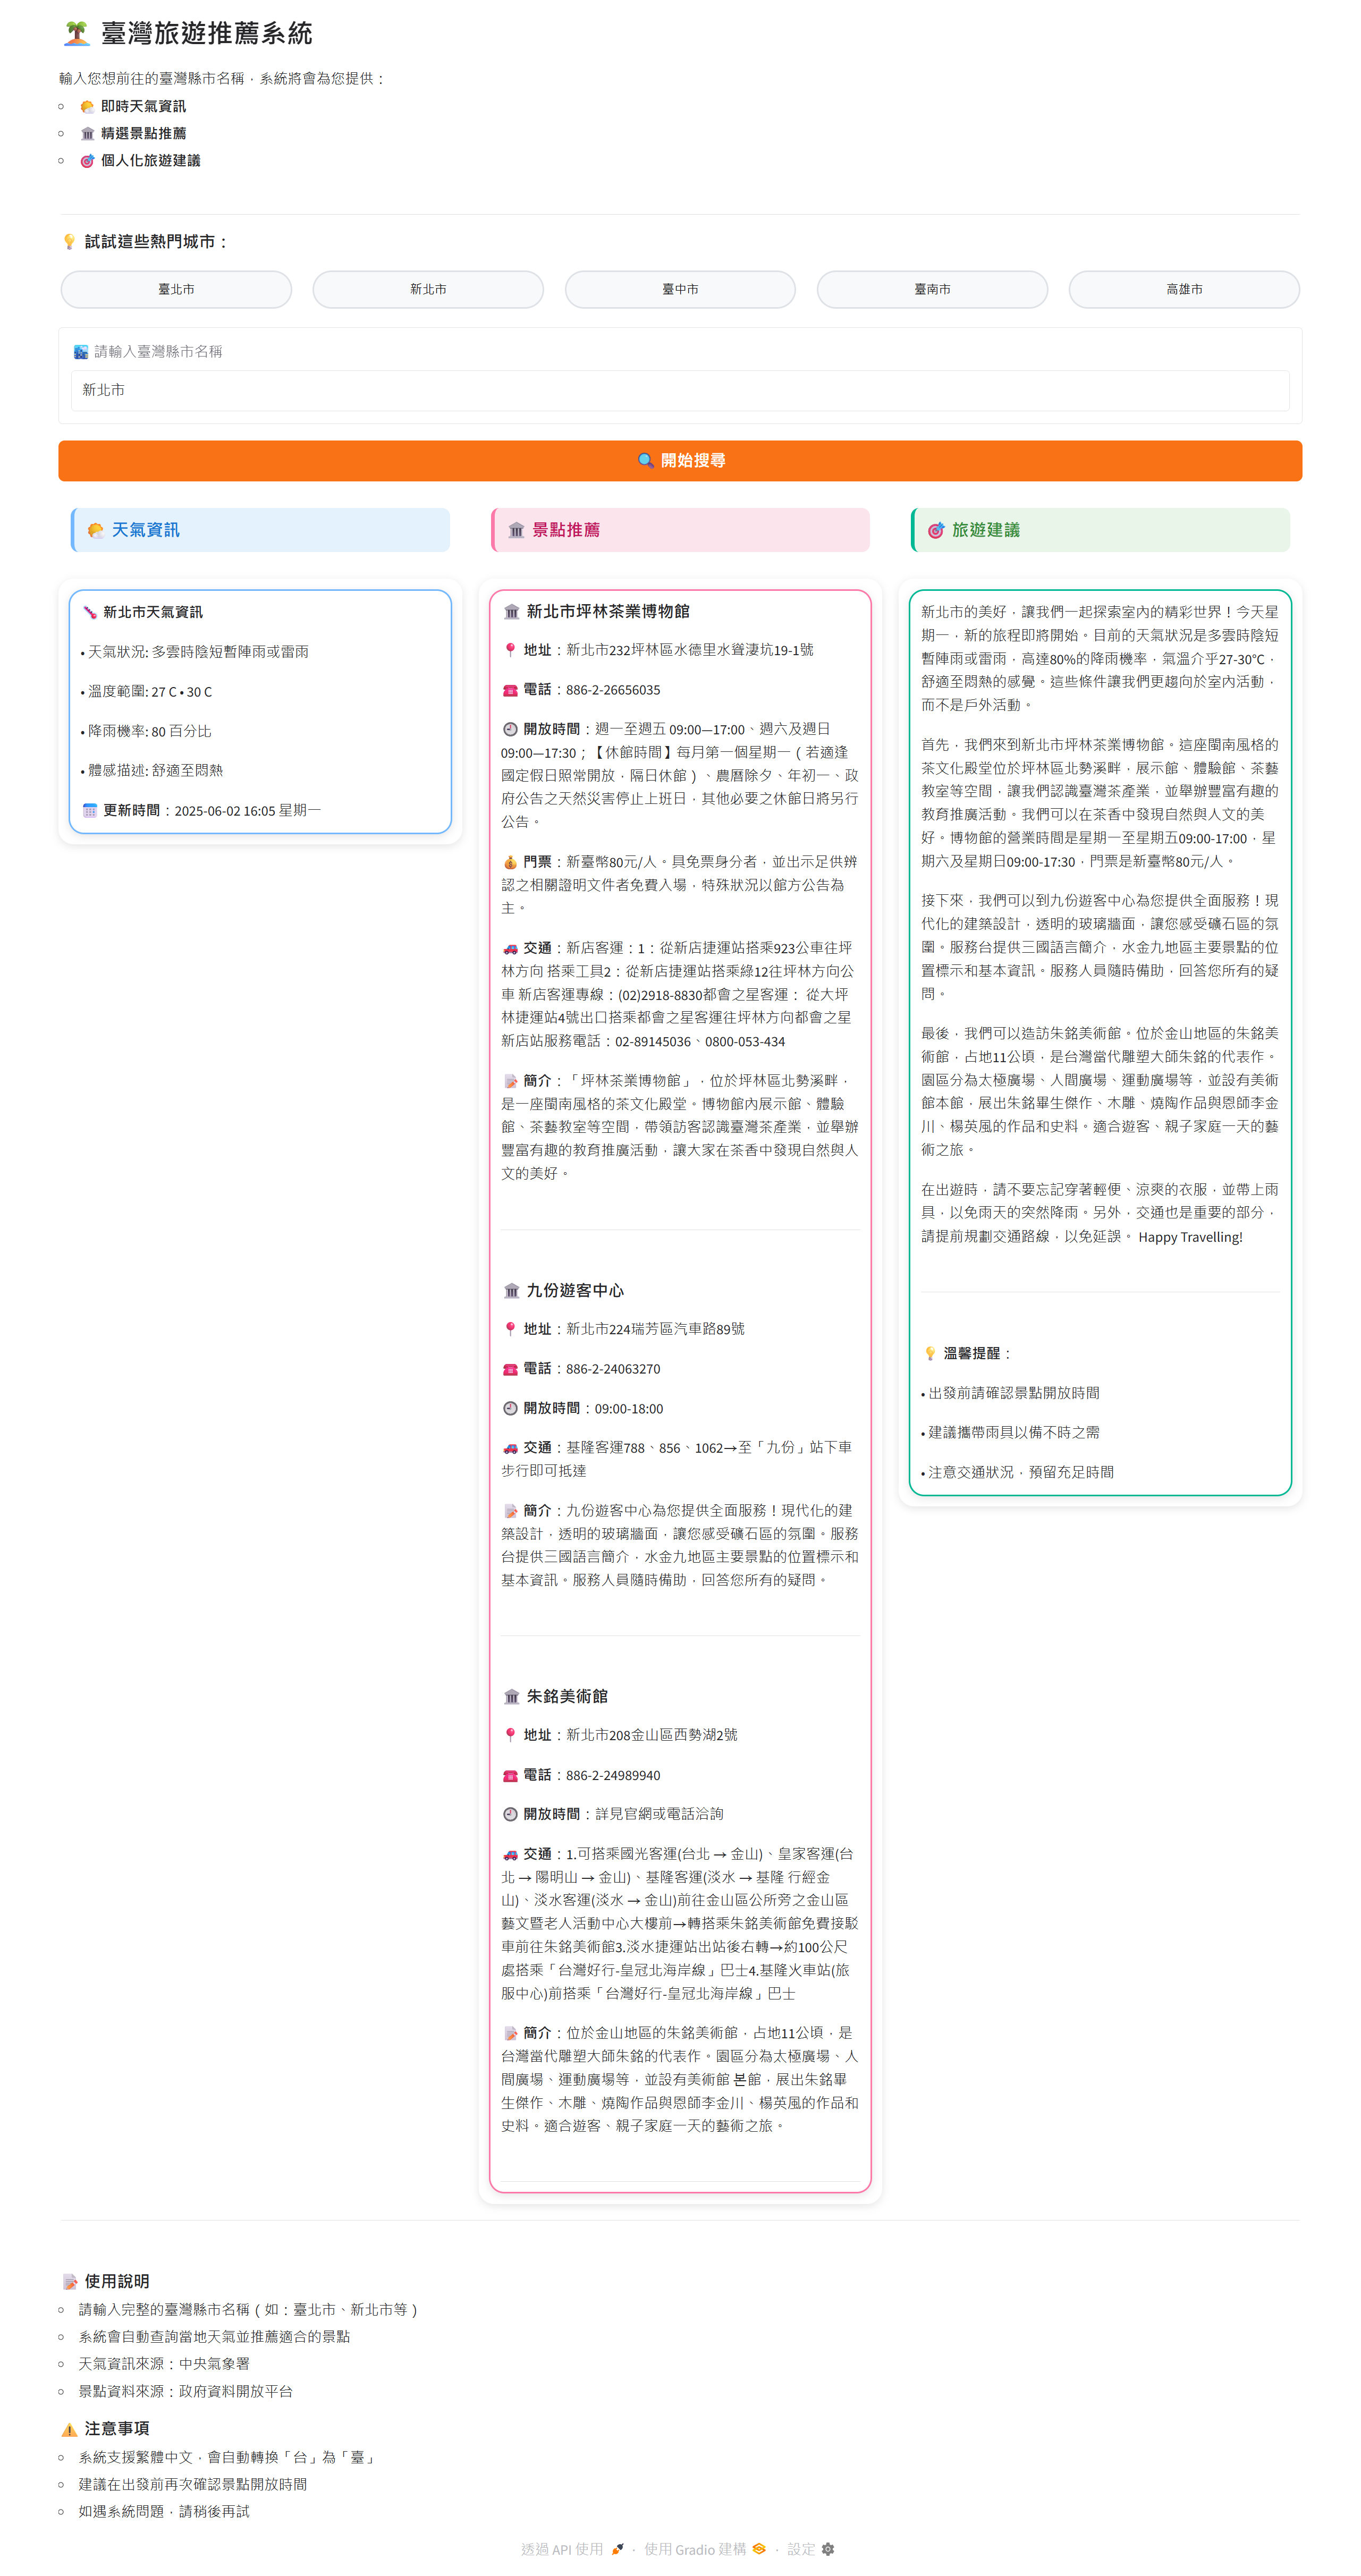